In [1]:
%load_ext autoreload
%autoreload 2
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from time import time
from tqdm import tqdm
from collections import defaultdict
from math import ceil
import seaborn as sns

from approxmh.utilities import *
from approxmh.vae import VAE, VAETrainer, get_filename
from approxmh.samplers import *
from approxmh.distributions import Banana, Funnel, create_gaussian_lattice, create_random_gaussian_mixture, get_mode_coverage
from approxmh.distribution_metrics import *
from approxmh.rnvp import RNVP
from approxmh.flow_trainer import FlowTrainer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


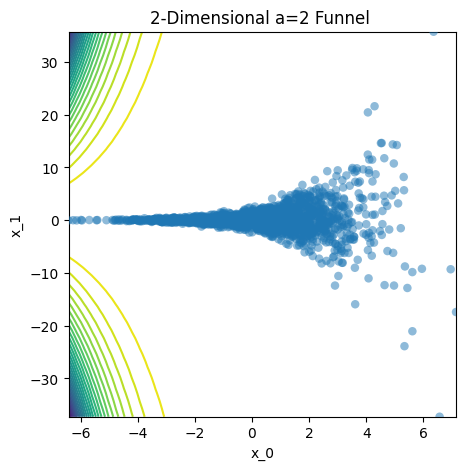

In [2]:
target_type = 2

if target_type == 0:  # Lattice
    target = create_gaussian_lattice(shape=(5, 5), variance=0.001, device=device)
elif target_type == 1:  # MoG
    target = create_random_gaussian_mixture(
        dim=5, n_components=50, mean_lim=(0, 1), 
        variance_lim=(0.01, 0.01), seed=43, device=device
    )
elif target_type == 2:  # Funnel
    target = Funnel(dim=2, a=2, device=device)

visualize_distribution(target, levels=30, dpi=50, plot_samples=True, sample_size=2000)

In [3]:
x_train = target.sample((512,))

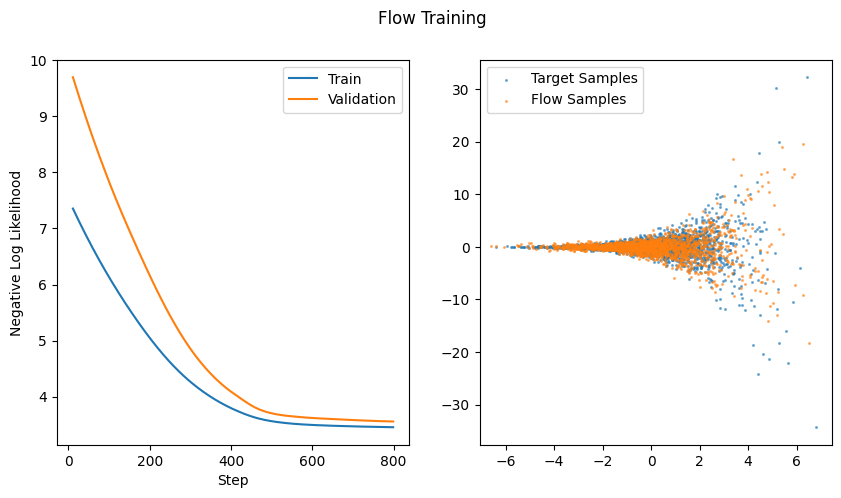

Epoch 799
	Train Loss: 3.4541
	Validation Loss: 3.5562
	Learning rate: 0.0007
CPU times: total: 8.16 s
Wall time: 8.29 s


In [4]:
%%time
flow = RNVP(num_blocks=7, dim=target.dim, device=device)
print('Flow parameters:', count_parameters(flow))
optimizer = torch.optim.SGD(flow.parameters(), lr=0.04, momentum=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=500)
flow_trainer = FlowTrainer(flow, target, scheduler=scheduler, batch_size=512, device=device, lr=0.0007)
flow_trainer.fit(x_train, n_epochs=400, plot_interval=20)

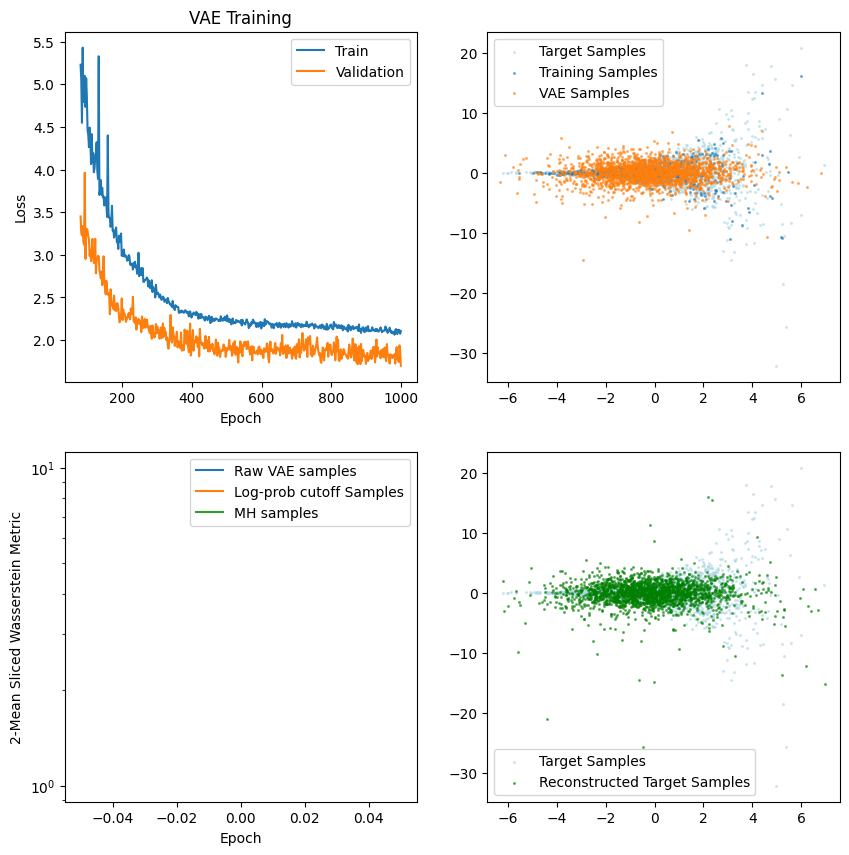

Epoch 999
	Train loss: 2.1050
	Validation loss: 1.6987
	Learning rate: 0.001
CPU times: total: 6.42 s
Wall time: 6.43 s


In [9]:
%%time

hidden_dims = (4, 4, 4)
vae = VAE(
    data_dim=target.dim,
    hidden_dims=hidden_dims,
    latent_dim=target.dim,
    device=device
) 
print('VAE parameters:', count_parameters(vae))
#optimizer = torch.optim.SGD(vae.parameters(), lr=0.05, momentum=0.9)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=500)
trainer = VAETrainer(
    vae, target, batch_size=512, no_kl_penalty_epochs=10, kl_annealing_epochs=100, 
    warmup_period=1, optimizer=optimizer, scheduler=scheduler, device=device
)
trainer.fit(x_train, n_epochs=500, plot_interval=10)

In [104]:
print('Flow parameters:', count_parameters(flow))
print('VAE parameters:', count_parameters(vae))
print(flow.training)
print(vae.training)

Flow parameters: 126
VAE parameters: 192
False
False


In [105]:
vae_log_ml_estimator = lambda x: vae.ais_log_marginal_estimate(
    x, kernel_type='mala', n_particles=32, n_steps=10,
    time_step=0.8, precondition=True,
)

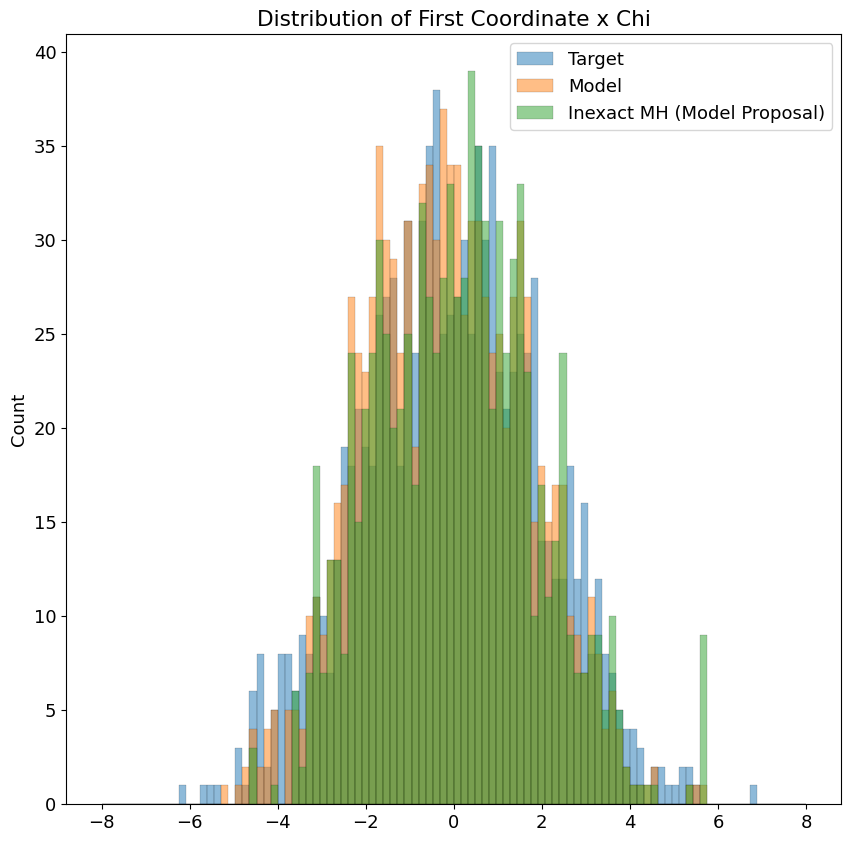

In [106]:
def analyze_feature_distribution(model, model_log_prob_estimator):
    plt.rcParams.update({'font.size': 13})
    N = 1000
    q = 0
    feature2 = lambda x: torch.linalg.vector_norm(x[..., 1:], dim=-1) * torch.exp(-x[..., 0] / 2)
    feature = lambda x: x[..., 0]
    feature_name = 'First Coordinate x Chi'
    
    target_samples = target.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)
    model_samples = model.sample((N,))
    # FLOW CRAZY:
    model_samples = model_samples[model_samples[..., 0] > -100]
    cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model_samples, target_quantile, return_indicies=False)
    
    mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator)

    plot_info = [
        (target_samples, 'Target', 'tab:blue'),
        (model_samples, 'Model', 'tab:orange'),
#        (cut_samples, 'VAE + Probability Cutoff', 'tab:red'),
        (mh_samples, f'Inexact MH (Model Proposal)', 'tab:green'),
    ]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    for sample, sample_name, sample_color in plot_info:
        sns.histplot(
            x=to_numpy(feature(sample)),
            alpha=0.5,
            label=sample_name,
            color=sample_color,
            linewidth=0.1,
#            binrange=((-7, 7), (5, 19)),
            binrange=(-8, 8),
            bins=100,
#            bw_adjust=0.2,
#            clip=(-10, 10)
        )
    # ax.set_xlim(-10, 60)
    ax.legend()
    #ax.set_title(f'{target_friendly_name}\nDistributions of {feature_name}\n({N} samples)', y=1)
    ax.set_title(f'Distribution of {feature_name}', y=1)
    #ax.get_yaxis().set_visible(False)

analyze_feature_distribution(vae, vae_log_ml_estimator)

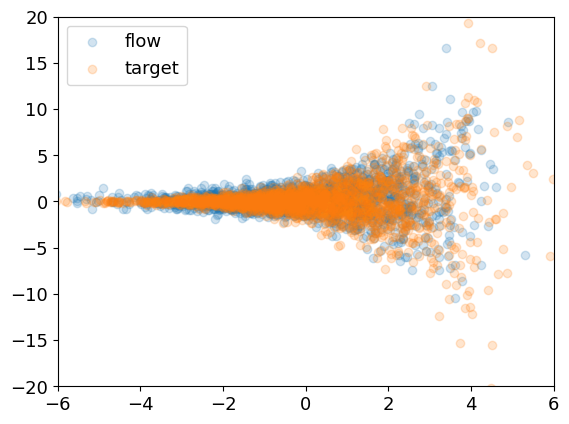

In [107]:
N = 2000
flow_samples = to_numpy(flow.sample((N,)))
target_samples = to_numpy(target.sample((N,)))
plt.scatter(*flow_samples[:, :2].T, alpha=0.2, label='flow')
plt.scatter(*target_samples[:, :2].T, alpha=0.2, label='target')
#sns.jointplot(x=flow_samples[..., 0], y=flow_samples[..., 1], fig=fig, alpha=0.5)
#sns.jointplot(x=target_samples[..., 0], y=target_samples[..., 1], fig=fig, alpha=0.5)
plt.xlim(-6, 6)
plt.ylim(-20, 20)
plt.legend();

In [108]:
metric = SlicedDistributionMetric(WassersteinMetric1d(), target.dim)
N = 5000

L = 512
beta = 1
vae_log_ml_estimator = lambda x : vae.iw_log_marginal_estimate(x, L=L, beta=beta, batch_L=64)
cutoff_log_prob = target.log_prob(x_train).quantile(0)

In [109]:
vae_samples = vae.sample((N,))
cut_vae_acc_rate, cut_vae_samples = log_prob_cutoff_filter(target, vae_samples, cutoff_log_prob, return_indicies=False)
mh_vae_acc_rate, mh_vae_samples = metropolis_hastings_filter(target, cut_vae_samples, vae_log_ml_estimator, max_density_ratio=14.5)

flow_samples = flow.sample((N,))
flow_samples = flow_samples[flow_samples[..., 0] > -100]
cut_flow_acc_rate, cut_flow_samples = log_prob_cutoff_filter(target, flow_samples, cutoff_log_prob, return_indicies=False)
mh_flow_acc_rate, mh_flow_samples = metropolis_hastings_filter(target, cut_flow_samples, flow.log_prob)

MH discarded 0 outlier(s)


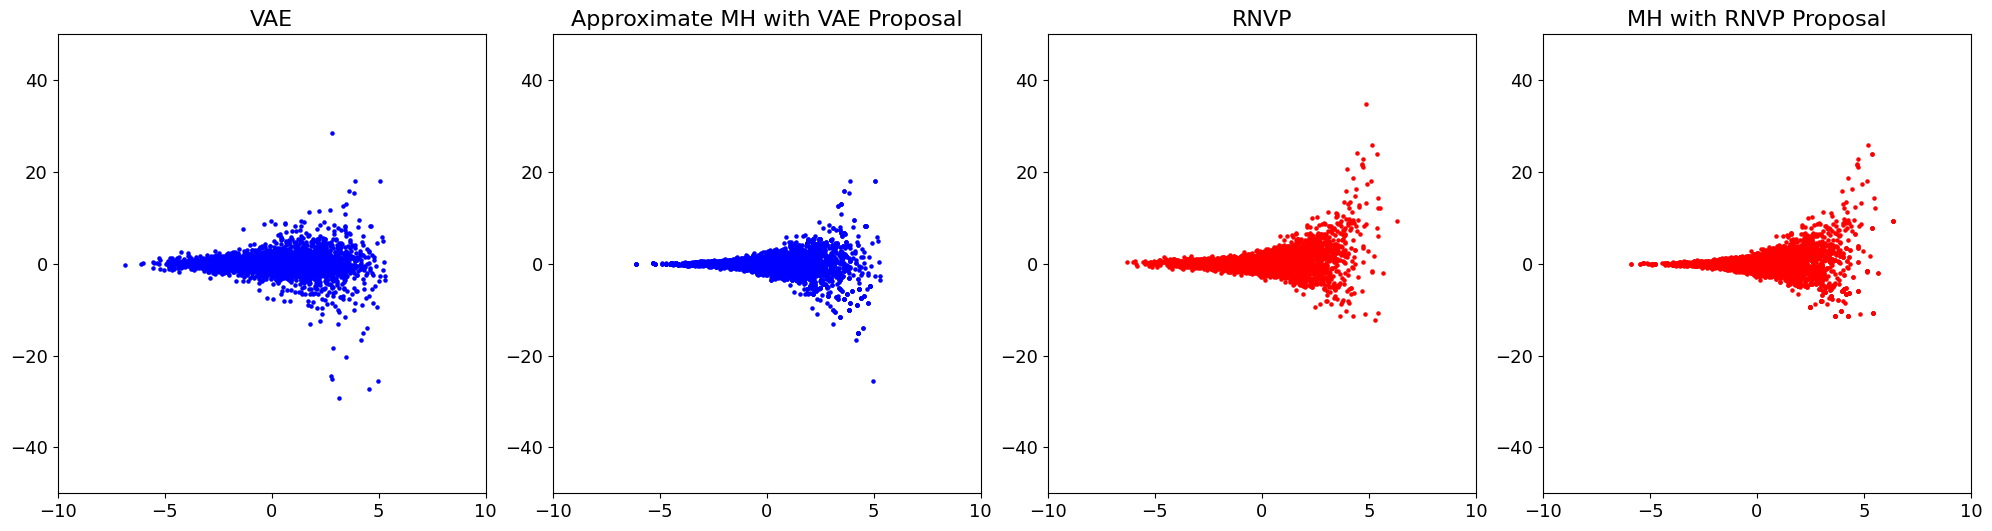

In [110]:
def sample_scatter(self, sample, **kwargs):
    return self.scatter(*pl(sample[:, (0, 1)]), s=20, marker='.', **kwargs)
mpl.axes.Axes.sample_scatter = sample_scatter

fontsize = 16
fig, axs = plt.subplots(figsize=(20, 5.5), ncols=4, nrows=1)
# fig.suptitle('Exact and Inexact Adaptive Proposal Metropolis-Hastings Comparison')
target_samples = target.sample((N,))
axs[0].sample_scatter(vae_samples, label='VAE', color='blue')
axs[0].set_title('VAE', fontsize=fontsize)
axs[1].sample_scatter(mh_vae_samples, label='VAE + MH', color='blue')
axs[1].set_title('Approximate MH with VAE Proposal', fontsize=fontsize)
axs[2].sample_scatter(flow_samples, label='RNVP', color='red')
axs[2].set_title('RNVP', fontsize=fontsize)
#axs[0].set_xlim(axs[1].get)
#axs[0].set_ylim(-1, 5)
#axs[2].set_xlim(-1, 5)
#axs[2].set_ylim(-1, 5)
axs[3].sample_scatter(mh_flow_samples, label='RNVP + MH', color='red')
axs[3].set_title('MH with RNVP Proposal', fontsize=fontsize)
plt.tight_layout()
for ax in axs.flatten():
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_xlim(-10, +10)
    ax.set_ylim(-50, +50)

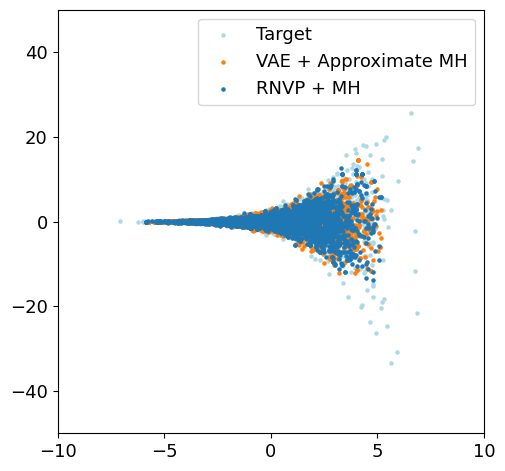

In [99]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))
# fig.suptitle('Exact and Inexact Adaptive Proposal Metropolis-Hastings Comparison')
target_samples = target.sample((N,))
ax.sample_scatter(target_samples, label='Target', color='lightblue')
ax.sample_scatter(mh_vae_samples, label='VAE + Approximate MH', color='tab:orange')
ax.sample_scatter(mh_flow_samples, label = 'RNVP + MH', color='tab:blue')
ax.set_xlim(-10, +10)
ax.set_ylim(-50, +50)
ax.legend()

In [198]:
def modes_lost(target, samples, k=1):
    return (get_mode_coverage(target, samples, k=k) == 0).sum().item()
print('vae', modes_lost(target, vae_samples, k=2))
print('vae + mh', modes_lost(target, mh_vae_samples, k=2))
print('flow', modes_lost(target, flow_samples, k=2))
print('flow + mh', modes_lost(target, mh_flow_samples, k=2))

vae 0
vae + mh 1
flow 0
flow + mh 0


In [204]:
N=1000
n_runs = 1000
k = 2
vae_modes_lost = []
flow_modes_lost = []
for run_id in range(n_runs):
    vae_samples = vae.sample((N,))
    #cut_vae_acc_rate, cut_vae_samples = log_prob_cutoff_filter(target, vae_samples, cutoff_log_prob, return_indicies=False)
    #mh_vae_acc_rate, mh_vae_samples = metropolis_hastings_filter(target, cut_vae_samples, vae_log_ml_estimator, max_density_ratio=14.5, n_estimates=10, return_indicies=False)
    vae_modes_lost.append(modes_lost(target, vae_samples, k=k))
    
    flow_samples = flow.sample((N,))
    #cut_flow_acc_rate, cut_flow_samples = log_prob_cutoff_filter(target, flow_samples, cutoff_log_prob, return_indicies=False)
    #mh_flow_acc_rate, mh_flow_samples = metropolis_hastings_filter(target, cut_flow_samples, flow.log_prob, return_indicies=False)
    flow_modes_lost.append(modes_lost(target, flow_samples, k=k))

print(f'{n_runs} runs')
for name, ml in zip(('VAE', 'Flow'), (vae_modes_lost, flow_modes_lost)):
    ml = torch.tensor(ml, dtype=torch.float)
    print(f'{name}: {ml.mean():0.3f} +- {ml.var().sqrt():0.3f}')

1000 runs
VAE: 0.185 +- 0.416
Flow: 0.001 +- 0.032
